In [1]:
# import pandas as pd
import datetime
import xarray as xr
from zutils.xr import xrwrap
import matplotlib.pyplot as plt
import importlib
import numpy as np

from pIMOS.xrwrap.WETLABS_NTU import WETLABS_NTU, parse_device_file


In [3]:
fn = r'G:\Experiments\kissme17\FLNTU\1835.log'
dfn = r'G:\Experiments\kissme17\FLNTU\Device Files\1835\FLNTUSB-1835.dev'
    
first_good = datetime.datetime(2017, 4, 2, 3, 0)
last_good = datetime.datetime(2018, 1, 1, 0)


# Parse the file
File will have no calibration information 

In [4]:

wetlab = WETLABS_NTU(fn)
wetlab.ds


Im a string
Updating attributes function of the class.
Setting attribute "title" to "Measured data from a TDRI ADCP read from .PD0 files"
Setting attribute "institution" to "UWA"
Setting attribute "source" to "TDRI ADCP [Workhorse, Quartermaster, or Longranger]"
Setting attribute "history" to ""
Setting attribute "references" to ""
Setting attribute "comment" to ""


<xarray.Dataset>
Dimensions:  (time: 67568)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-02T03:13:42 ... 2017-04-26T02:46:54
Data variables:
    c1       (time) float64 695.0 695.0 695.0 695.0 ... 695.0 695.0 695.0 695.0
    c2       (time) float64 49.0 48.0 48.0 49.0 48.0 ... 54.0 54.0 52.0 53.0
    c3       (time) float64 700.0 700.0 700.0 700.0 ... 700.0 700.0 700.0 700.0
    c4       (time) float64 50.0 50.0 50.0 50.0 50.0 ... 495.0 476.0 489.0 460.0
    c5       (time) float64 519.0 519.0 519.0 519.0 ... 552.0 551.0 552.0 552.0
    c6       (time) float64 1.632e+04 1.632e+04 ... 1.632e+04 1.632e+04
    c7       (time) float64 1.602e+04 1.6e+04 1.6e+04 ... 1.602e+04 1.6e+04

## Note
The attributes in the above are blank. All the CF stuff is a property of the Wetlabs Object, and only pushed to the ds on exporting to xarray.

## Calibrate
#### 'Manual' calibration 
If you don't have a device file you can calibrate manually:

In [5]:

column = 4
SF=0.1 # This is a silly number 
DC=52
wetlab._calibrate_turbidity(SF, DC, column)


c4


Which adds new variables to the xarray Dataset. We plot this now but Turbidity will be way too high as the numbers are way off. 


Text(0.5, 1.0, 'Turbidity calculated with silly coefs.')

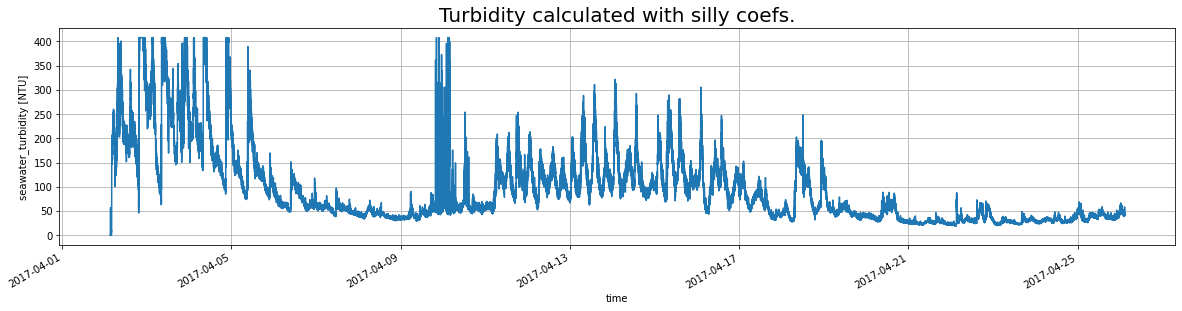

In [6]:
%matplotlib inline
plt.figure(figsize=(20, 4))
wetlab.ds['turbidity'].plot()
plt.grid()
plt.title('Turbidity calculated with silly coefs.', fontsize=20)

####  Calibration with a device file 
If you have a device file, send it in like this:

In [7]:
wetlab._calibrate_device(dfn)

Wetlab model:FLNTUSB
Wetlab FLNTUSBserial number:1835
Date device file created:10/15/14
File contains  calibration information for:
     Chlorophyll
     Turbidity
c4
c2
Device file calibration complete.


Now we'll have both Turbidity and Chlorophyll

Text(0.5, 1.0, 'Chlorophyll calculated with device file.')

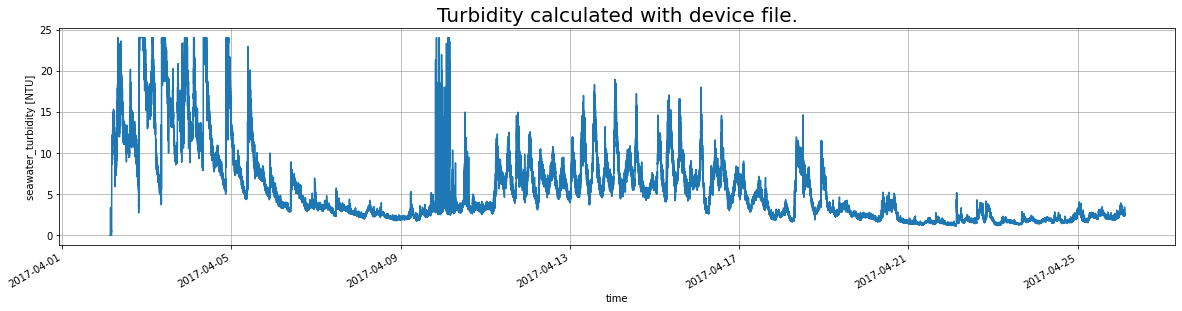

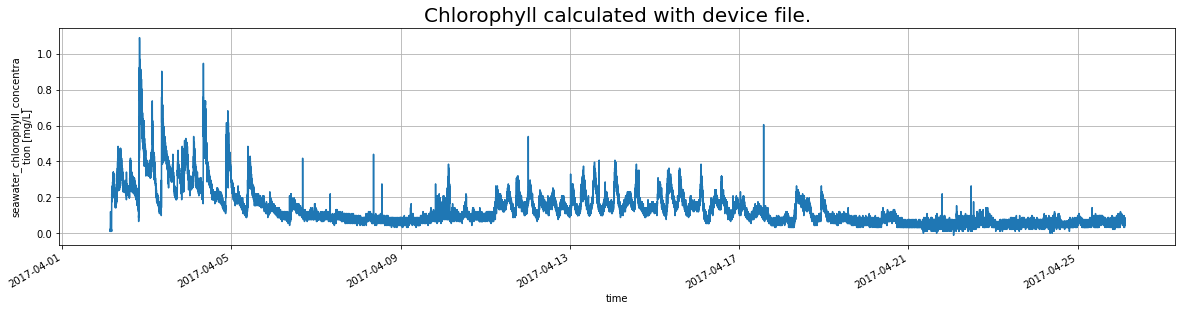

In [8]:
%matplotlib inline
plt.figure(figsize=(20, 4))
wetlab.ds['turbidity'].plot()
plt.grid()
plt.title('Turbidity calculated with device file.', fontsize=20)

plt.figure(figsize=(20, 4))
wetlab.ds['chlorophyll'].plot()
plt.grid()
plt.title('Chlorophyll calculated with device file.', fontsize=20)


# Cut ends out of file
Could just flag these but I prefer to cut them altogether as it simplifies the burst processing. 

Good data from 2017-04-02 03:00:00 to 2018-01-01 00:00:00
Trimmed Time


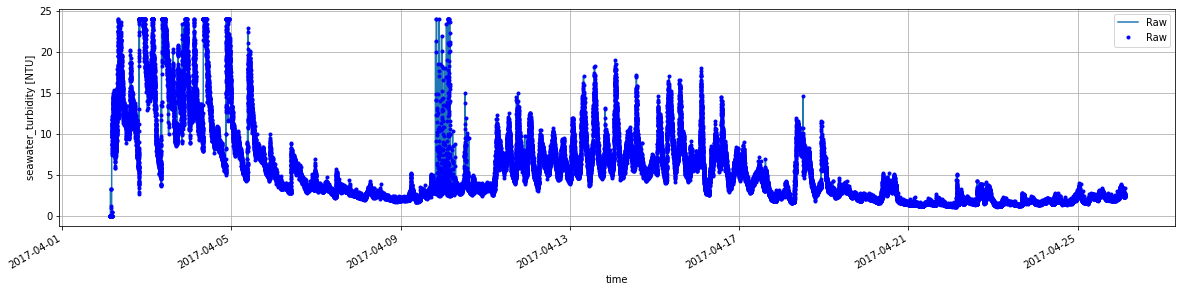

In [9]:
wetlab.time_trim(first_good, last_good)

%matplotlib inline
ds = wetlab.ds
plt.figure(figsize=(20, 4))
ds['turbidity'].plot(label='Raw')
plt.plot(ds['time'], ds['turbidity'], 'b.', label='Raw')
plt.grid()
plt.legend()


## Burst Median
Need to implement some code for this

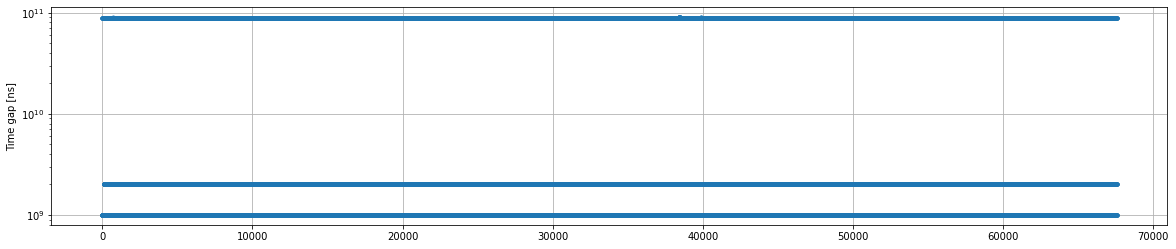

In [10]:
dt = np.diff(wetlab.ds['time'])

plt.figure(figsize=(20, 4))
plt.plot(dt, '.')
plt.grid()
plt.ylabel('Time gap [ns]')
plt.yscale('log')

In [11]:
wetlab._calc_burst_mean()
ds = wetlab.ds
ds

Splitting bursts using a cutoff of 3066573919 nanoseconds


<xarray.Dataset>
Dimensions:                     (burst_time: 22523, time: 67568)
Coordinates:
  * time                        (time) datetime64[ns] 2017-04-02T03:13:42 ......
  * burst_time                  (burst_time) datetime64[ns] 2017-04-02T03:13:...
Data variables: (12/13)
    c1                          (time) float64 695.0 695.0 695.0 ... 695.0 695.0
    c2                          (time) float64 49.0 48.0 48.0 ... 54.0 52.0 53.0
    c3                          (time) float64 700.0 700.0 700.0 ... 700.0 700.0
    c4                          (time) float64 50.0 50.0 50.0 ... 489.0 460.0
    c5                          (time) float64 519.0 519.0 519.0 ... 552.0 552.0
    c6                          (time) float64 1.632e+04 1.632e+04 ... 1.632e+04
    ...                          ...
    turbidity                   (time) float64 -0.0118 -0.0118 ... 2.578 2.407
    chlorophyll                 (time) float64 0.022 0.011 0.011 ... 0.055 0.066
    burst_mean_turbidity        (burst_time) float64 -0.0118 -0.0118 ... 2.493
    burst_median_turbidity      (burst_time) float64 -0.0118 -0.0118 ... 2.493
    burst_std_turbidity         (burst_time) float64 0.0 0.0 ... 0.09395 0.08555
    burst_median_mad_turbidity  (burst_time) float64 0.0 0.0 ... 0.118 0.08555

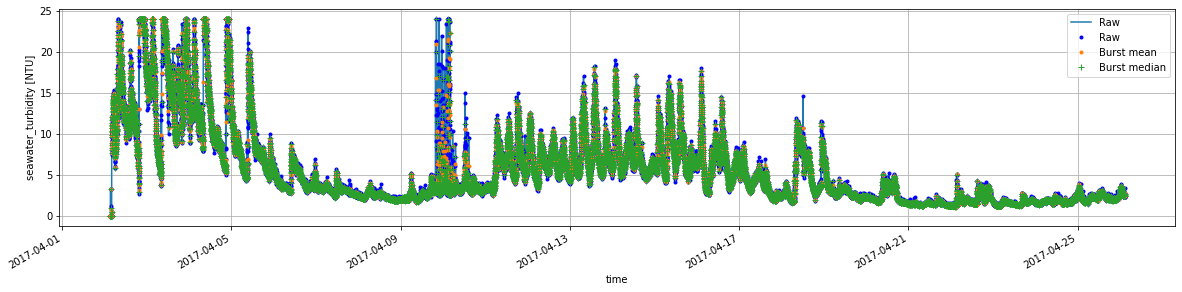

In [12]:
%matplotlib inline
plt.figure(figsize=(20, 4))
ds['turbidity'].plot(label='Raw')
plt.plot(ds['time'], ds['turbidity'], 'b.', label='Raw')
plt.plot(ds['burst_time'], ds['burst_mean_turbidity'], '.', label='Burst mean')
plt.plot(ds['burst_time'], ds['burst_median_turbidity'], '+', label='Burst median')
plt.grid()
plt.legend()


## Goring Nikora (2002)
This is implemented in turbo_tools, implement it here also. 

In [13]:
from turbo_tools.classes.misc import  binner
from turbo_tools.turbo import clean
from turbo_tools.utils.misc import  fillgaps

def clean_despike(self, block_length_seconds=3600*24*10, nit = 10, intensity=1, block=None):
    """
    Run the despike algorithm.

    """

    n = len(self.ds.burst_time)
    fs = 1e9/np.median(np.diff(wetlab.ds.burst_time)).item()
    print(1/fs)
    
    despike_binner = binner(n, fs, block_length_seconds, block_length_seconds)

    turb = self.ds.burst_median_turbidity.values.copy()

    sn = np.sum(np.sum(np.isnan(turb)))
    print('Nans in the intial data set: {}'.format(sn)) 

    if type(block)==type(None):
        # Do all blocks with limited output
        rng = np.arange(0, despike_binner.blocks)
        verbose = False
    else:
        # Do the requested block with full verbose output
        rng = np.arange(block, block+1)
        verbose = True

    for bb in rng:

        print('Despiking {}'.format(bb))

        ind = despike_binner.get_block_index(bb)

        for ii in np.arange(nit):

            try:
                x = turb[ind]

                X = clean.despike(x, fs, intensity = intensity, interp_opt='linear', n_it=nit, verbose=verbose)

                if verbose:
                    sn = np.sum(np.sum(np.isnan(X)))
                    print('Nans in the cleaned block: {}'.format(sn)) 

                turb[ind] = X

                turb = fillgaps(turb) # Fill gaps again - the previous filler won't get end gaps [probably shouldn't remove end gaps but that's another story]. 

                if verbose:
                    sn = np.sum(np.sum(np.isnan(vel_xyz)))
                    print('Nans in the final data set: {}'.format(sn))
            except:
                print('THIS IS NO GOOD')
                pass
            
    return turb, despike_binner
            
cl, despike_binner = clean_despike(wetlab, intensity = 1, nit=10)

92.0
Nans in the intial data set: 0
Despiking 0
Despiking 1


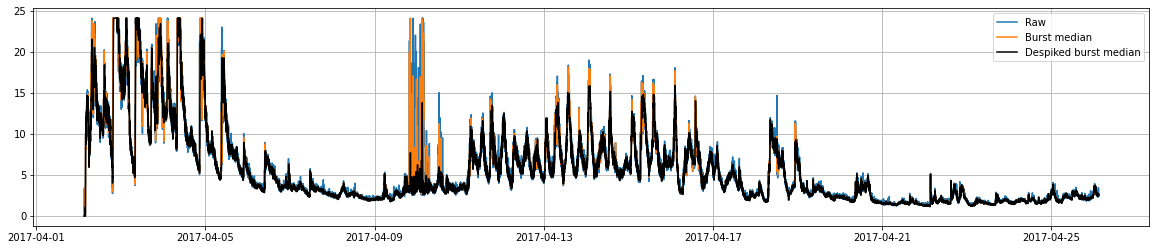

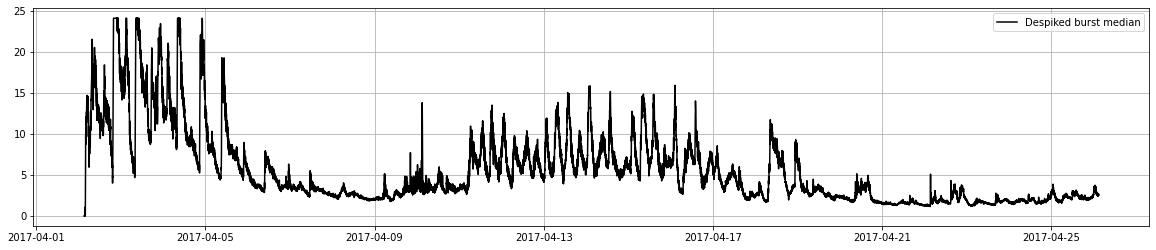

In [14]:
%matplotlib inline

plt.figure(figsize=(20, 4))
plt.plot(wetlab.ds.time, wetlab.ds.turbidity, label='Raw')
plt.plot(wetlab.ds.burst_time, wetlab.ds.burst_median_turbidity, label='Burst median')
plt.plot(wetlab.ds.burst_time, cl, 'k', label='Despiked burst median')
plt.grid()
plt.legend()

plt.figure(figsize=(20, 4))
plt.plot(wetlab.ds.burst_time, cl, 'k', label='Despiked burst median')
plt.grid()
plt.legend()
